In [ ]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [ ]:
# reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
TRAIN_DATA_PATH = 'data/imagewoof2/train'
TEST_DATA_PATH = 'data/imagewoof2/val'
BATCH_SIZE = 128
CROP_SIZE = 224

MODEL_SAVE_PATH = 'pretrained/resnet50.pth'

In [ ]:
import os

os.chdir('..')

# Data

In [ ]:
!python src/data_load.py --config params.yaml --size full

In [ ]:
from torchvision.transforms import *
from src.utils import Cutout

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
normalize_transform = Normalize(mean, std)

test_transforms = Compose([Resize(CROP_SIZE), CenterCrop(CROP_SIZE),
                           ToTensor(), normalize_transform])

train_transforms = Compose([RandomApply([RandomRotation(15, fill=(127,127,127))], p=0.8),
                            RandomAffine(degrees=0, scale=(0.83, 1.2), translate=(0.1, 0.1), fillcolor=(127,127,127)),
                            Resize(CROP_SIZE), CenterCrop(CROP_SIZE),
                            RandomHorizontalFlip(p=0.5),
                            ToTensor(), 
                            RandomApply([Cutout(size=50, color=(0.5,0.5,0.5))], p=0.5),
                            normalize_transform])

test_dataset = ImageFolder(TEST_DATA_PATH, test_transforms)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2*BATCH_SIZE, 
                                              num_workers=2, pin_memory=True,
                                              shuffle=False, drop_last=False)

train_dataset = ImageFolder(TRAIN_DATA_PATH, train_transforms)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, 
                                               num_workers=2, pin_memory=True,
                                               shuffle=True, drop_last=True)

Посмотрим на картинки с тестовыми и тренировочными аугментациями:

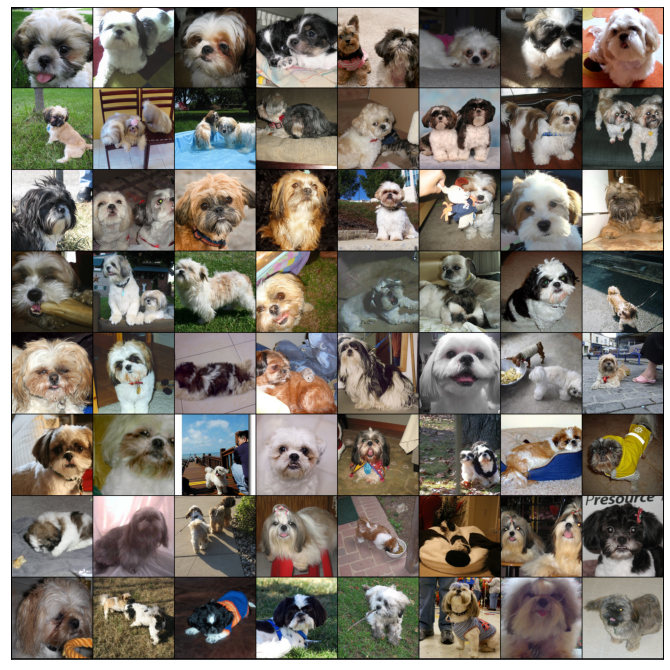

In [ ]:
from src.utils import show_batch

tmp_loader = torch.utils.data.DataLoader(ImageFolder(TEST_DATA_PATH, 
                                         test_transforms), batch_size=BATCH_SIZE)
batch = next(iter(tmp_loader))
show_batch(batch, mean, std)

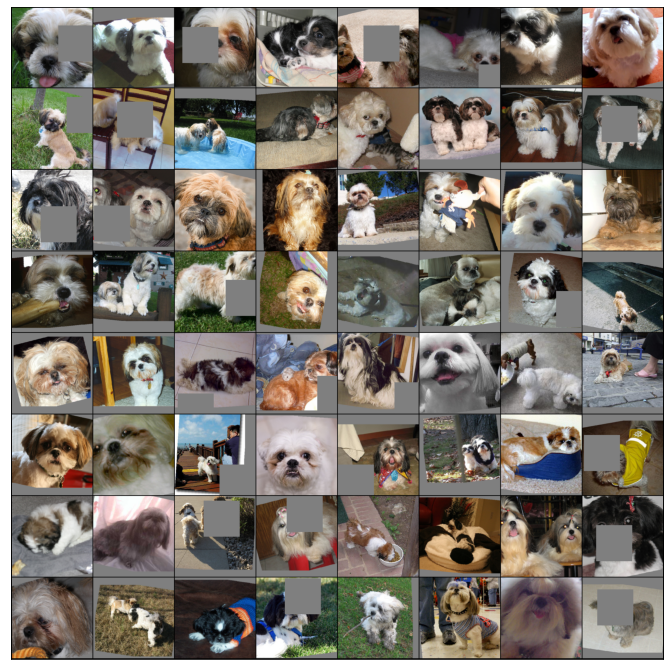

In [ ]:
tmp_loader = torch.utils.data.DataLoader(ImageFolder(TEST_DATA_PATH, 
                                         train_transforms), batch_size=BATCH_SIZE)
batch = next(iter(tmp_loader))
show_batch(batch, mean, std)

# Training

In [ ]:
model = torchvision.models.resnet50(pretrained=True)

In [ ]:
class HeadE(nn.Module):
    def __init__(self, input_size, output_size, dropout_p):
        super(HeadE, self).__init__()
        self.bn = nn.BatchNorm1d(input_size)
        self.drop = nn.Dropout(dropout_p, inplace=True)
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, input):
        x = self.bn(input)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [ ]:
model.fc = HeadE(model.fc.in_features, len(train_dataset.classes), dropout_p=0.5)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device);

In [ ]:
loss_fn = F.cross_entropy
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3)

In [ ]:
from src.training import train
from src.utils import get_logger

epochs = 5

model_name = os.path.basename(MODEL_SAVE_PATH).split('.')[0]
log_path = os.path.join(os.path.dirname(MODEL_SAVE_PATH), model_name + '.log')
logger = get_logger(log_path)

train(model, train_dataloader, test_dataloader, loss_fn, optimizer, epochs, device,
      logger, MODEL_SAVE_PATH, scheduler)

2021-03-04 22:11:45 Start training with params:
2021-03-04 22:11:45 loss_fn: torch.nn.functionalcross_entropy
2021-03-04 22:11:45 optimizer: SGD({'lr': 0.001, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': False})
2021-03-04 22:11:45 scheduler: ReduceLROnPlateau{'factor': 0.1, 'min_lrs': [0], 'patience': 3, 'verbose': False, 'cooldown': 0, 'cooldown_counter': 0, 'mode': 'min', 'threshold': 0.0001, 'threshold_mode': 'rel', 'best': inf, 'num_bad_epochs': 0, 'mode_worse': inf, 'eps': 1e-08, 'last_epoch': 0}
2021-03-04 22:11:45 train dataloader: batch_size=128
transform=Compose(
    RandomApply(
    p=0.8
    RandomRotation(degrees=[-15.0, 15.0], resample=False, expand=False, fill=(127, 127, 127))
)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.83, 1.2), fillcolor=(127, 127, 127))
    Resize(size=224, interpolation=PIL.Image.BILINEAR)
    CenterCrop(size=(224, 224))
    RandomHorizontalFlip(p=0.5)
    ToTensor()
    RandomApply(
    p=0.5
)
    No

# Metrics

In [ ]:
from src.utils import predict

pred_labels, losses = predict(model, test_dataloader, F.cross_entropy, device)

100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, \
                            confusion_matrix, ConfusionMatrixDisplay

print('Accuracy: {:.4}'.format(accuracy_score(test_dataset.targets, pred_labels)))

Accuracy: 0.9605


Classification report:

In [ ]:
print(classification_report(test_dataset.targets, pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       409
           1       0.95      0.98      0.96       408
           2       0.94      0.94      0.94       418
           3       0.88      0.86      0.87       224
           4       0.97      0.96      0.96       401
           5       0.96      0.95      0.95       407
           6       0.97      0.97      0.97       401
           7       0.99      0.99      0.99       422
           8       0.98      1.00      0.99       429
           9       0.96      0.96      0.96       410

    accuracy                           0.96      3929
   macro avg       0.96      0.96      0.96      3929
weighted avg       0.96      0.96      0.96      3929



Значительно хуже остальных предсказывается класс под индексом 3.

Confusion matrix:

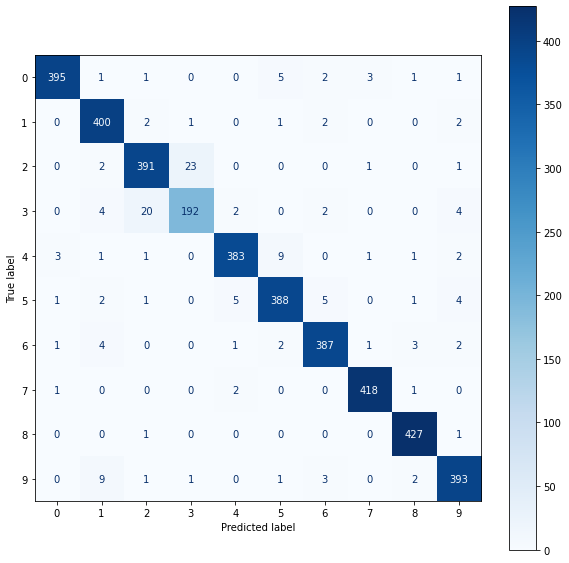

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(test_dataset.targets, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(len(test_dataset.classes))))

fig, ax = plt.subplots()
ax.figure.set_size_inches(10,10)
disp.plot(ax=ax, values_format='.4g', cmap='Blues');

Наиболее часто путаются классы 2 и 3. Можно попробовать назначить им больший вес в лосс-функции.

In [ ]:
class_to_imgs_num = []

for root, dirs, files in os.walk(TRAIN_DATA_PATH):
    if len(files) == 0:
        continue
    class_to_imgs_num.append((test_dataset.class_to_idx[os.path.basename(root)],
                                len(files)))

print(dict(sorted(class_to_imgs_num, key=lambda x: x[0])))

{0: 941, 1: 942, 2: 932, 3: 580, 4: 949, 5: 943, 6: 949, 7: 928, 8: 921, 9: 940}


Примеров третьего класса меньше остальных. Можно попробовать оверсэмплинг: сохранить на диск аугментации этого класса. Или добавить вес классу в лоссе.

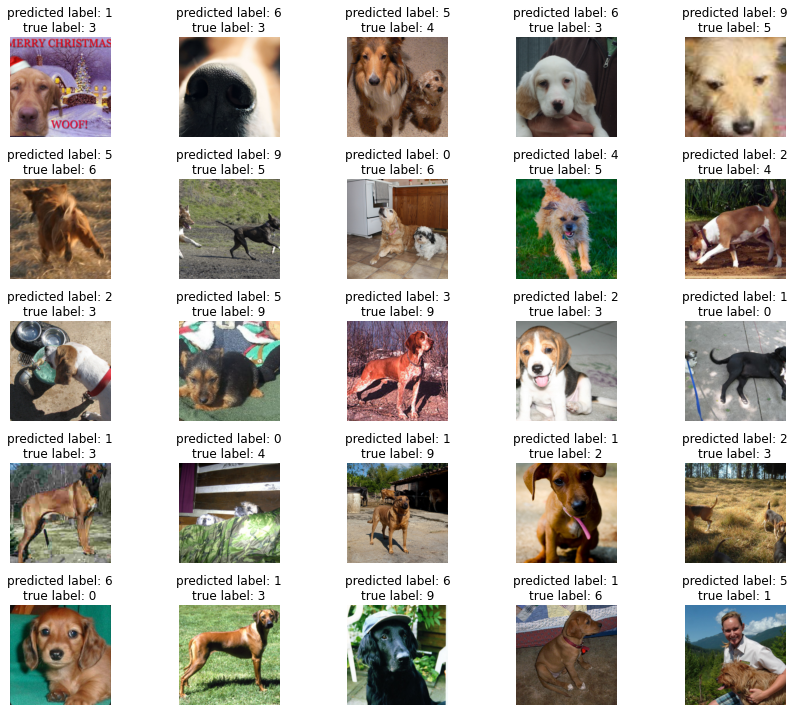

In [ ]:
from src.utils import show_top_k_misclassified

show_top_k_misclassified(25, pred_labels, losses, test_dataset, mean, std)